In [2]:
import pandas as pd

from tqdm import tqdm
from sklearn import preprocessing
from scipy import stats

from news_vec.utils import read_json_gz_lines

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [4]:
def sort_d1d2(df):
    d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
    df.drop(['d1', 'd2'], 1)
    df['d1'] = d1s
    df['d2'] = d2s
    return df

In [5]:
dfc = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ob.json/'))))
dfc = sort_d1d2(dfc)

955500it [00:02, 383867.96it/s]


In [6]:
dfa = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/window-actor-corrs.json/'))))
dfa = sort_d1d2(dfa)

9555it [00:00, 271473.69it/s]


In [7]:
dfc_mean = dfc.groupby(['d1', 'd2', 'window']).mean().reset_index()

In [8]:
pairs = set(map(tuple, dfc[['d1', 'd2']].values.tolist()))

In [11]:
rows = []
for d1, d2 in pairs:
    
    pdfc = dfc_mean[(dfc_mean.d1==d1)&(dfc_mean.d2==d2)].sort_values('window')
    pdfa = dfa[(dfa.d1==d1)&(dfa.d2==d2)].sort_values('window')
    
    corr, p = stats.kendalltau(-pdfc.acc, pdfa['corr'])
    rows.append((d1, d2, corr, p))

In [12]:
corr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))
corr_df['label'] = corr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [13]:
corr_df.mean()['corr']

0.010714576428862145

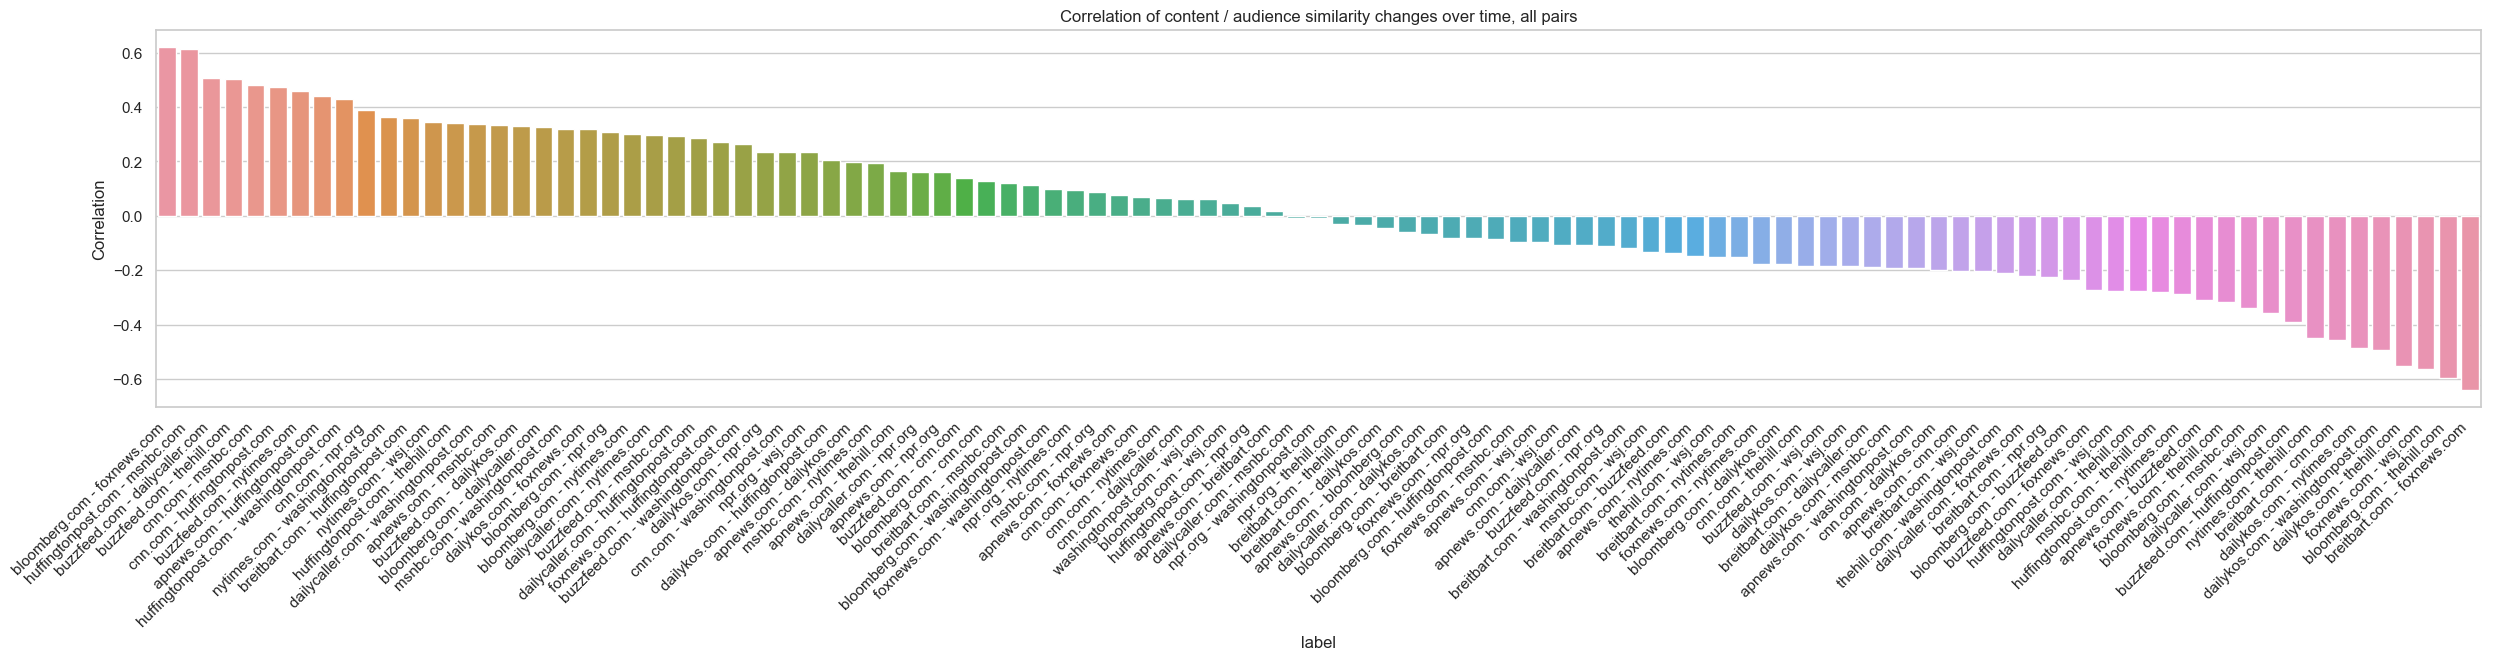

In [14]:
plt.figure(figsize=(30,5), dpi=100)
sns.barplot(y='corr', x='label', data=corr_df.sort_values('corr', ascending=False))
plt.xticks(rotation=45, ha='right')

plt.title('Correlation of content / audience similarity changes over time, all pairs')
plt.ylabel('Correlation')
plt.savefig('figures/ts-ca-corrs.png', bbox_inches='tight')

In [33]:
def plot_pair(d1, d2, dst=None):
    
    pdfc = dfc_mean[(dfc_mean.d1==d1)&(dfc_mean.d2==d2)].sort_values('window').copy()
    pdfc['score'] = -preprocessing.scale(pdfc.acc)
    
    pdfa = dfa[(dfa.d1==d1)&(dfa.d2==d2)].sort_values('window')
    pdfa['score'] = preprocessing.scale(pdfa['corr'])
    
    plt.figure(figsize=(4,3), dpi=100)
    sns.lineplot(x='window', y='score', data=pdfc, label='content')
    sns.lineplot(x='window', y='score', data=pdfa, label='audience')
    
    plt.title(f'{d1} / {d2}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')
    
    plt.show()

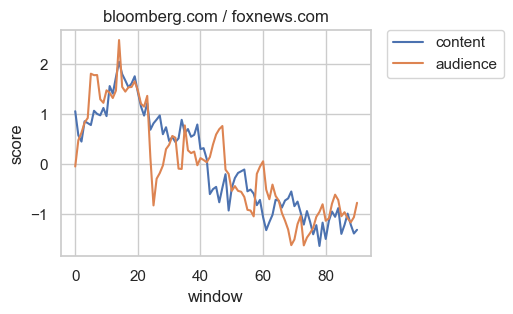

In [36]:
plot_pair('bloomberg.com', 'foxnews.com', 'figures/fox-bloomberg-corr.png')

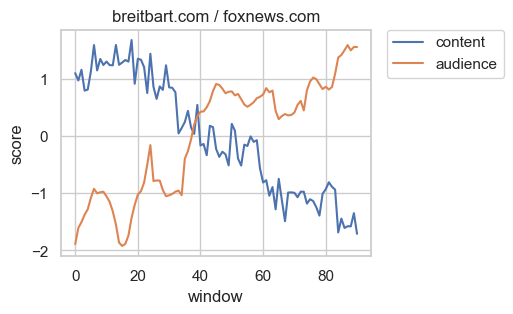

In [47]:
plot_pair('breitbart.com', 'foxnews.com', 'figures/fox-breitbart-corr.png')

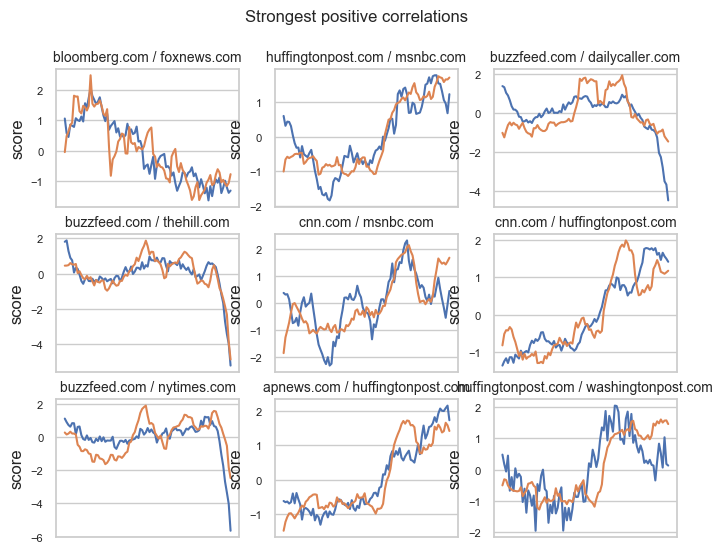

In [49]:
fig, axes = plt.subplots(3, 3, sharex=True, figsize=(8,6), dpi=100)

for i, r in enumerate(corr_df.sort_values('corr', ascending=False).head(9).itertuples()):
    
    ax = axes.reshape(-1)[i]
    ax.set_title(f'{r.d1} / {r.d2}', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xticks([])
    
    pdfc = dfc_mean[(dfc_mean.d1==r.d1)&(dfc_mean.d2==r.d2)].sort_values('window').copy()
    pdfc['score'] = -preprocessing.scale(pdfc.acc)
    
    pdfa = dfa[(dfa.d1==r.d1)&(dfa.d2==r.d2)].sort_values('window')
    pdfa['score'] = preprocessing.scale(pdfa['corr'])
    
    sns.lineplot(x='window', y='score', data=pdfc, ax=ax)
    sns.lineplot(x='window', y='score', data=pdfa, ax=ax)
    
plt.suptitle('Strongest positive correlations')
fig.subplots_adjust(hspace=0.2, bottom=0.1)
plt.savefig('figures/ts-ca-pos-corrs.png', bbox_inches='tight')

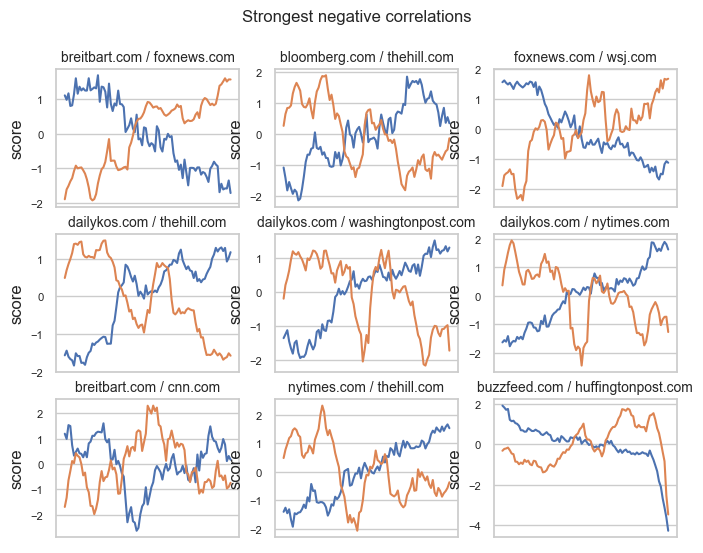

In [50]:
fig, axes = plt.subplots(3, 3, sharex=True, figsize=(8,6), dpi=100)

for i, r in enumerate(corr_df.sort_values('corr', ascending=True).head(9).itertuples()):
    
    ax = axes.reshape(-1)[i]
    ax.set_title(f'{r.d1} / {r.d2}', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xticks([])
    
    pdfc = dfc_mean[(dfc_mean.d1==r.d1)&(dfc_mean.d2==r.d2)].sort_values('window').copy()
    pdfc['score'] = -preprocessing.scale(pdfc.acc)
    
    pdfa = dfa[(dfa.d1==r.d1)&(dfa.d2==r.d2)].sort_values('window')
    pdfa['score'] = preprocessing.scale(pdfa['corr'])
    
    sns.lineplot(x='window', y='score', data=pdfc, ax=ax)
    sns.lineplot(x='window', y='score', data=pdfa, ax=ax)
    
plt.suptitle('Strongest negative correlations')
fig.subplots_adjust(hspace=0.2, bottom=0.1)
plt.savefig('figures/ts-ca-neg-corrs.png', bbox_inches='tight')